In [88]:
import pyarrow as pa
import pyarrow.parquet as pq

import pandas as pd

import matplotlib.pyplot as plt

In [89]:
actors = pq.read_table("data/actors.parquet")
actors_df = actors.to_pandas()

actors_df

,id,uri,label,jurisdictions,categories
0,bilaxy,bilaxy.com,Bilaxy,HK,exchange
1,banxa,banxa.com,Banxa,"AU, NL, US",exchange
2,aax,www.aax.com,Aax,SC,exchange
3,altcointrader,www.altcointrader.co.za,AltcoinTrader,ZA,exchange
4,azbit,azbit.com,Azbit,MH,exchange
...,...,...,...,...,...
309,stocksexchange,stex.com,Stex,EE,exchange
310,smenarnabitcoin,smenarnabitcoin.cz,Smenarnabitcoin,CZ,exchange
311,xapo,xapo.com,Xapo,US,"exchange, service"
312,yobit,yobit.net,YoBit,RU,exchange


Lets see how the jurisdictions are "distributed"

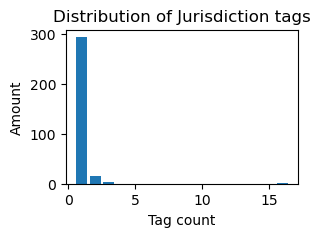

In [90]:
# Compute the comma count for each value in the "jurisdictions" column
comma_count_stats = actors_df['jurisdictions'].apply(lambda x: str(x).count(',')+1).value_counts().sort_index()


plt.figure(figsize=(3, 2)) 
plt.bar(comma_count_stats.index, comma_count_stats.values)
plt.xlabel('Tag count')
plt.ylabel('Amount')
plt.title('Distribution of Jurisdiction tags')
plt.show()

who has 16 jurisdictions????

In [91]:
actors_df[actors_df['jurisdictions'].str.count(',') == 15]


,id,uri,label,jurisdictions,categories
35,binance,binance.com,"Binance (US, DEX)","AE, AU, BH, CA, CY, ES, FR, IT, KY, KZ, LT, MT...","defi_dex, exchange, mining_service, organization"


of course its binance LOL

In [92]:
flows = pq.read_table("data/flows.parquet")
flows_df = flows.to_pandas()

flows_df

,src_id,dst_id,value_asset,value_USD,date
0,1coin,1coin,36870000,243.755870,2014-03-03
1,1coin,1coin,380120000,2378.899210,2014-03-10
2,1coin,1coin,429150403,2738.687542,2014-03-13
3,1coin,1coin,333900098,2092.574397,2014-03-14
4,1coin,1coin,779334803,4938.373652,2014-03-15
...,...,...,...,...,...
1939582,zyado,zyado,1019592,11.368847,2017-03-21
1939583,zyado,zyado,1004152,13.325487,2017-04-29
1939584,zyado,zyado,39850720,5966.967603,2018-01-10
1939585,zyado,zyado,19251202,1730.115174,2018-04-27
